# Управление рисками 2026

## Часть 1. График линейности признака по WoE.

В этой части домашки мы познакомимся с одним из основных инструментов для анализа переменных в модели логистической регрессии - графиком линейности.

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем woe-line руками, чтобы в деталях разобраться, как он строится.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

### Шаг 0: разбиение на бакеты

In [ ]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [ ]:
# протестируйте calc_buckets

x = np.array([10, 20, 30, 40, 50])
calc_buckets(x, n_buckets=5)

array([0, 1, 2, 3, 4], dtype=int16)

In [ ]:
x = np.array([50, 10, 40, 20, 30])
calc_buckets(x, n_buckets=5)

array([4, 0, 3, 1, 2], dtype=int16)

In [ ]:
x = np.array([50, 10, 40, 30, 30])
calc_buckets(x, n_buckets=5)

array([4, 1, 3, 2, 2], dtype=int16)

Ура ура, все работает!

### Шаг 1: расчет WoE по бакетам (2 балла)

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$.

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**:

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big )
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

Пусть "доля плохих" равна:

$$
b_i = \frac{B_i}{B_i + G_i}, \quad b = \frac{B}{B + G}
$$

Тогда логит для бакета:

$$
\text{logit}(b_i) = \ln \frac{b_i}{1-b_i} = \ln \frac{B_i/(B_i+G_i)}{G_i/(B_i+G_i)} = \ln \frac{B_i}{G_i}
$$

Аналогично для всей выборки:

$$
\text{logit}(b) = \ln \frac{B}{G}
$$

Следовательно:

$$
\text{WoE}_i(x) = \ln\frac{B_i}{G_i} - \ln\frac{B}{G} = \text{logit}(b_i) - \text{logit}(b)
$$


In [ ]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

Здесь и далее предлагается протестироать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [ ]:
# протестируй woe_transform

Пусть у нас есть бакет, в котором B = 3, G = 7

В выборке: B = 30, G = 70

In [ ]:
# вычислим WoE двумя способами

badrate_bucket = 3 / (3 + 7)
badrate_sample = 30 / (30 + 70)

# по формуле через ln(B/G)
woe_ln = np.log(badrate_bucket) - np.log(badrate_sample)

# через logit
woe_logit = logit(badrate_bucket) - logit(badrate_sample)

print(f'WoE через ln(B/G): {woe_ln}')
print(f'WoE через logit: {woe_logit}')

WoE через ln(B/G): 0.0
WoE через logit: 0.0


Формула справедлива, теперь протестируем нашу функцию

In [ ]:
# для одного бакета

offset = logit(badrate_sample)

woe_value = woe_transform(badrate_bucket, offset)
print(f'WoE для бакета: {woe_value}')

WoE для бакета: 0.0


In [ ]:
# для разных бакетов

buckets = [0.1, 0.2, 0.5, 0.7, 0.9]
woes = [woe_transform(b, offset) for b in buckets]
print(f'WoE для разных бакетов: {woes}')

WoE для разных бакетов: [np.float64(-1.3499267169490154), np.float64(-0.5389965007326869), np.float64(0.8472978603872037), np.float64(1.6945957207744071), np.float64(3.0445224377234235)]


Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

In [ ]:
from scipy.stats import norm

In [ ]:
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float, alpha=0.05) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    # считаем бэдрейт и доверительный интервал для него (любым способом)

    z = norm.ppf(1 - alpha / 2)

    badrate_list, badrate_lower_list, badrate_upper_list = [], [], []
    woe_list, woe_lower_list, woe_upper_list = [], [], []

    for b in np.unique(buckets):
        idx = buckets == b
        n_i = idx.sum()
        B_i = target[idx].sum()
        G_i = n_i - B_i

        b_i = B_i / n_i
        eps = 1e-6
        b_i = np.clip(b_i, eps, 1 - eps) # ограничила, чтобы не было ошибок (осоебнно на маленьких выборках)
        se = np.sqrt(b_i * (1 - b_i) / n_i)

        # ДИ
        b_lower = b_i - z * se
        b_upper = b_i + z * se

        badrate_list.append(b_i)
        badrate_lower_list.append(b_lower)
        badrate_upper_list.append(b_upper)

        # переходим от бэдрейта к woe

        woe_list.append(woe_transform(b_i, offset))
        woe_lower_list.append(woe_transform(b_lower, offset))
        woe_upper_list.append(woe_transform(b_upper, offset))

    badrate = pd.Series(badrate_list, index=np.unique(buckets))
    badrate_lower = pd.Series(badrate_lower_list, index=np.unique(buckets))
    badrate_upper = pd.Series(badrate_upper_list, index=np.unique(buckets))

    woe = pd.Series(woe_list, index=np.unique(buckets))
    woe_lower = pd.Series(woe_lower_list, index=np.unique(buckets))
    woe_upper = pd.Series(woe_upper_list, index=np.unique(buckets))

    return woe, woe_lower, woe_upper

### Шаг 2: расчет линейной интерполяции (1 балл)

In [ ]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    model = LogisticRegression()
    model.fit(values.reshape(-1,1), target)

    proba = model.predict_proba(mean_feature.reshape(-1,1))[:,1]
    line = woe_transform(proba, offset)
    return line

In [ ]:
# протестируйте calc_line

values = np.array([1,2,3,4,5,6,7,8,9,10])
target = np.array([0,0,0,1,0,1,1,1,0,1])
mean_feature = np.array([1.5, 3.5, 5.5, 7.5, 9.5])
offset = logit(target.mean())

woe_line = calc_line(values, target, mean_feature, offset)
print(woe_line)

[-1.63586554e+00 -8.17944475e-01 -2.34087825e-05  8.17897657e-01
  1.63581872e+00]


### Шаг3: собираем результаты по бакетам в один словарь (1 балл)

In [ ]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""

    unique_buckets = np.unique(buckets)
    mean_feature = np.array([values[buckets == b].mean() for b in unique_buckets])
    offset = logit(target.mean())
    line = calc_line(values, target, mean_feature, offset)
    woe, woe_lower, woe_upper = woe_ci(target, buckets, offset)

    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : line,
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

In [ ]:
# протестируйте calc_buckets_info

values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
target = np.array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1])
buckets = calc_buckets(values, n_buckets=2)

calc_buckets_info(values, target, buckets)

{'mean_feature': array([3., 8.]),
 'line': array([-1.02242474,  1.02237792]),
 'woe': 0   -1.386294
 1    1.386294
 dtype: float64,
 'woe_lower': 0         NaN
 1   -0.203132
 dtype: float64,
 'woe_upper': 0    0.203132
 1         NaN
 dtype: float64}

### Шаг 4: считаем метрики признака (2 балла)

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам.

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

ROC AUC показывает способность признака ранжировать наблюдения, но не учитывает распределение good/bad внутри бакетов

IV дополнительно отражает силу разделения классов по всему диапазону признака и позволяет интерпретировать вклад признака в модель

In [ ]:
from sklearn.metrics import roc_auc_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    auc = roc_auc_score(target, values)

    # формула выше
    IV = 0.0
    unique_buckets = np.unique(buckets)
    B = target.sum()
    G = len(target) - B

    woe, _, _ = woe_ci(target, buckets, offset=logit(B/(B+G)))

    for b in unique_buckets:
        idx = buckets == b
        B_i = target[idx].sum()
        G_i = len(idx) - B_i
        IV += ((B_i/B) - (G_i/G)) * woe[b]

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете

    mean_feature = np.array([values[buckets == b].mean() for b in unique_buckets])
    woe_values = woe.values  # из pandas.Series в массив
    weights = np.array([np.sum(buckets==b) for b in unique_buckets])

    w_mean_x = np.average(mean_feature, weights=weights)
    w_mean_y = np.average(woe_values, weights=weights)

    SS_tot = np.sum(weights * (woe_values - w_mean_y)**2)

    w_cov_xy = np.sum(weights * (mean_feature - w_mean_x) * (woe_values - w_mean_y))
    w_var_x = np.sum(weights * (mean_feature - w_mean_x)**2)

    b = w_cov_xy / w_var_x
    a = w_mean_y - b * w_mean_x

    y_pred = a + b * mean_feature

    SS_res = np.sum(weights * (woe_values - y_pred)**2)

    R_sqr = 1 - SS_res / SS_tot


    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [ ]:
# протестируйте calc_plot_title

values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
target = np.array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1])

buckets = calc_buckets(values, n_buckets=4)

calc_plot_title(values, target, buckets)

'AUC = 0.800 IV = 11.330 R_sqr = 0.372 '

Видим ошибку (так как маленькая выборка), добавила ограничение в woe_ci

In [ ]:
# протестируйте calc_plot_title

values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
target = np.array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1])

buckets = calc_buckets(values, n_buckets=4)

calc_plot_title(values, target, buckets)

'AUC = 0.800 IV = 11.330 R_sqr = 0.372 '

### Шаг 5: собираем все в одну функцию и строим график

In [ ]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [ ]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [ ]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

<Axes: xlabel='feature', ylabel='Count'>

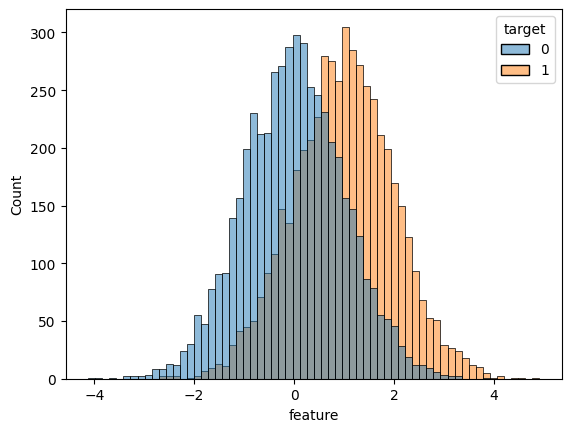

In [ ]:
sns.histplot(df, x = 'feature', hue = 'target')

In [ ]:
# запустите после того, как реализуете все функции
woe_line(values=x, target=y, n_buckets=5)

### Эксперименты (2 балл)

#### №1

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)?

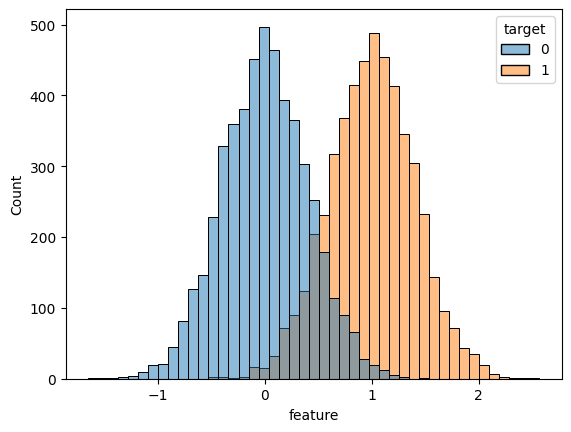

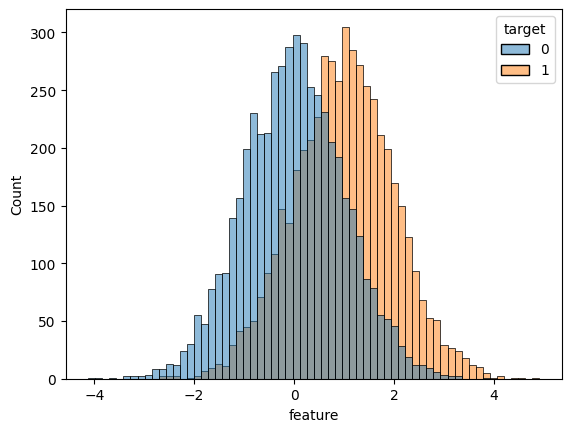

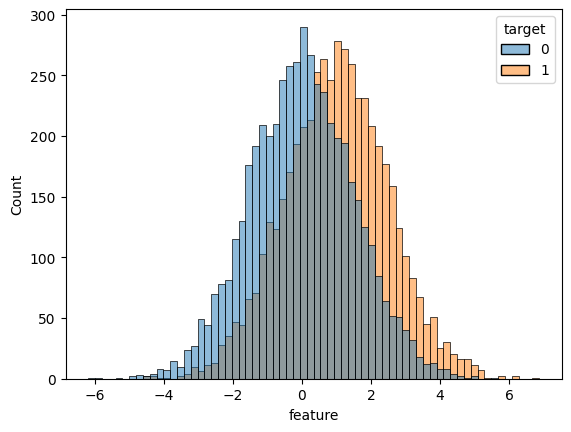

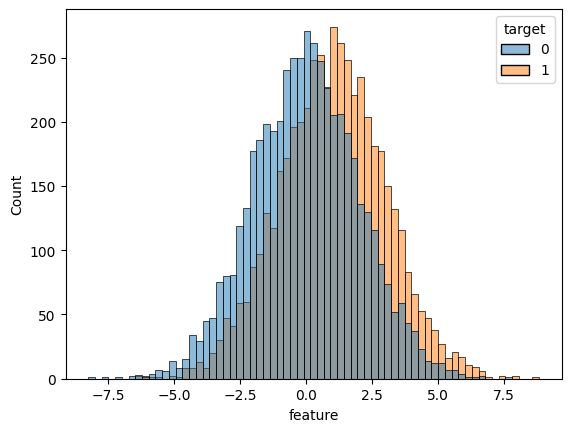

In [ ]:
import matplotlib.pyplot as plt

sample_size = int(1e4)
noise_stds =  [0.4, 1.0, 1.5, 2.0]

y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])

for noise_std in noise_stds:
    np.random.seed(89)
    x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])

    df = pd.DataFrame({'target': y, 'feature': x})

    sns.histplot(df, x = 'feature', hue = 'target')
    plt.show()

    fig = woe_line(values=x, target=y, n_buckets=5)
    fig.show()

При увеличении дисперсии шума распределения классов начинают сильнее наслаиваться друг на друга, из-за чего и график WoE становится менее линейным

В результате ROC AUC и IV уменьшаются, так как признак хуже разделяет классы, R2 тоже уменьшается, поскольку зависимость теперь менее линейна

#### №2

Запустите функцию с `values=x ** 2`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [ ]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x ** 2, target=y, n_buckets=5)

Теперь зависимость таргета от признака уже не линейна. По графику видно, что точки для WoE уже не лежат на прямой, образуя выпуклую кривую, а линия логистической регрессии проходит далеко не через все точки + R2 упал

В таком случае для продолжения работы с логрегом можно линеаризовать признак (np.log(x), np.sqrt(x)) + можно разбить признак на линейные участки + можно ограничить признак на концах

#### №3

Запустите функцию с `values=np.exp(x)`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [ ]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=np.exp(x), target=y, n_buckets=5)

Теперь зависимость также не линейна. Точки для WoE еще сильнее не лежат на прямой, образуя экспоненциальную кривую, а линия логистической регрессии проходит только через 1 точку (и то не совсем) + R2 сильно упал

В таком случае для продолжения работы с логрегом можно линеаризовать признак (np.log(x)) + можно разбить признак на линейные участки + можно ограничить признак на концах

## Часть 2. Строим ЛогРег. (5 баллов)

В этом пунтке попробуем применить все наши навыки

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/Nca7PoTNYokXgNF). Пароль вы найдете в телеграм-канале курса, в посте с анонсом домашки.

In [ ]:
df = pd.read_csv('risks-24-hw1.csv', index_col=0)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.000119,0.029628,3.829880,1,8.825418,3.829880,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.062686,0.859062,6.189545,1,3.453220,6.189545,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.339225,0.614599,12.503629,1,-10.116061,12.503629,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.938956,0.090461,-1.080041,1,6.780814,-1.080041,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.067646,0.216199,1.367184,1,-10.638134,1.367184,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.949937,0.224437,5.263508,1,-9.959913,5.263508,5.294558,-524.265291,-1.648415,5.410059,0.855190,B,0
99996,0.222451,-0.273191,0.380895,0.860607,0.950708,0.581767,1,-1.645952,0.581767,5.571499,-13.499956,3.386865,92.903615,0.006668,A,1
99997,1.078498,0.339526,-5.184847,0.242072,0.854085,0.995075,1,-5.565932,0.995075,-0.433263,3.928387,3.290285,1.233853,0.160933,A,1
99998,-1.431421,-0.605388,2.466023,-0.056519,0.736255,2.980562,1,-4.517188,2.980562,10.812813,-507.593408,-1.398568,1904.246147,0.077164,B,1


Как вы выдите, ```feature_1, ..., feature_14``` - числа
```feature_15``` - категориальная фича

### Задание 0. EDA.

Как бы вы начали знакомиться с данными до построения модели? Постройте 3-5 графиков / таблиц, чтобы передать основную информацию о датасете.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   feature_1   100000 non-null  float64
 1   feature_2   100000 non-null  float64
 2   feature_3   100000 non-null  float64
 3   feature_4   100000 non-null  float64
 4   feature_5   100000 non-null  float64
 5   feature_6   100000 non-null  float64
 6   feature_7   100000 non-null  int64  
 7   feature_8   100000 non-null  float64
 8   feature_9   100000 non-null  float64
 9   feature_10  100000 non-null  float64
 10  feature_11  100000 non-null  float64
 11  feature_12  100000 non-null  float64
 12  feature_13  100000 non-null  float64
 13  feature_14  100000 non-null  float64
 14  feature_15  100000 non-null  object 
 15  d4p12       100000 non-null  int64  
dtypes: float64(13), int64(2), object(1)
memory usage: 13.0+ MB


In [ ]:
df.isna().sum()

,0
feature_1,0
feature_2,0
feature_3,0
feature_4,0
feature_5,0
feature_6,0
feature_7,0
feature_8,0
feature_9,0
feature_10,0


Всего по 1 пропуску в 4 переменных

По базе посмотрим на описательные статистики

In [ ]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,d4p12
count,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,-0.004065,-0.198827,-6.283870,-1.251609e-01,1.001067,2.990486,0.900280,-2.514795,2.990486,3.640370,-256.924907,1.013153,9.969348e+02,2.885691e-01,0.425370
std,2.625003,169.576125,2344.152317,5.900464e-01,1.003677,3.997014,0.299628,5.009291,3.997014,4.977886,260.742462,2.314468,4.699415e+03,3.785086e-01,0.494401
min,-54.598150,-38296.171946,-10000.000000,-1.999985e+00,0.000009,-18.732375,0.000000,-26.496544,-18.732375,-16.847030,-1012.820365,-9.210340,1.666947e-19,6.195140e-11,0.000000
25%,-1.011666,-0.385200,-4.215224,-2.219215e-01,0.287134,0.288999,1.000000,-5.893561,0.288999,0.270052,-506.548930,-1.262413,3.451754e+00,1.371482e-03,0.000000
50%,-0.058406,-0.072894,0.003200,-2.735552e-09,0.694543,3.001134,1.000000,-2.511154,3.001134,3.669848,-282.922772,-0.800022,2.341854e+01,4.439380e-02,0.000000
75%,1.004057,0.395806,4.255211,1.096505e-01,1.383918,5.688353,1.000000,0.859395,5.688353,6.984301,-0.080408,3.344923,1.536384e+02,6.085319e-01,1.000000
max,39.011329,20133.753873,10000.000000,9.999525e-01,11.629614,21.549778,1.000000,19.258719,21.549778,24.764462,446.685530,3.951220,3.729609e+05,1.000000e+00,1.000000


Признаки разного масштаба, стоит стандартизировать переменые

Вероятно, d4p12 — наш таргет, посмотрим на него

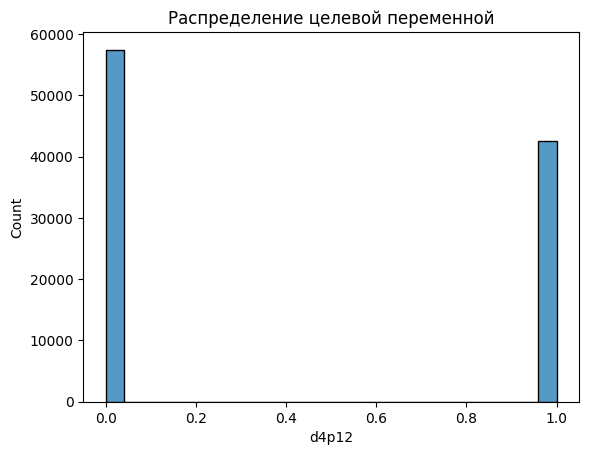

In [ ]:
sns.histplot(df['d4p12'])
plt.title('Распределение целевой переменной')
plt.show()

Дисбаланс значений не слишком велик

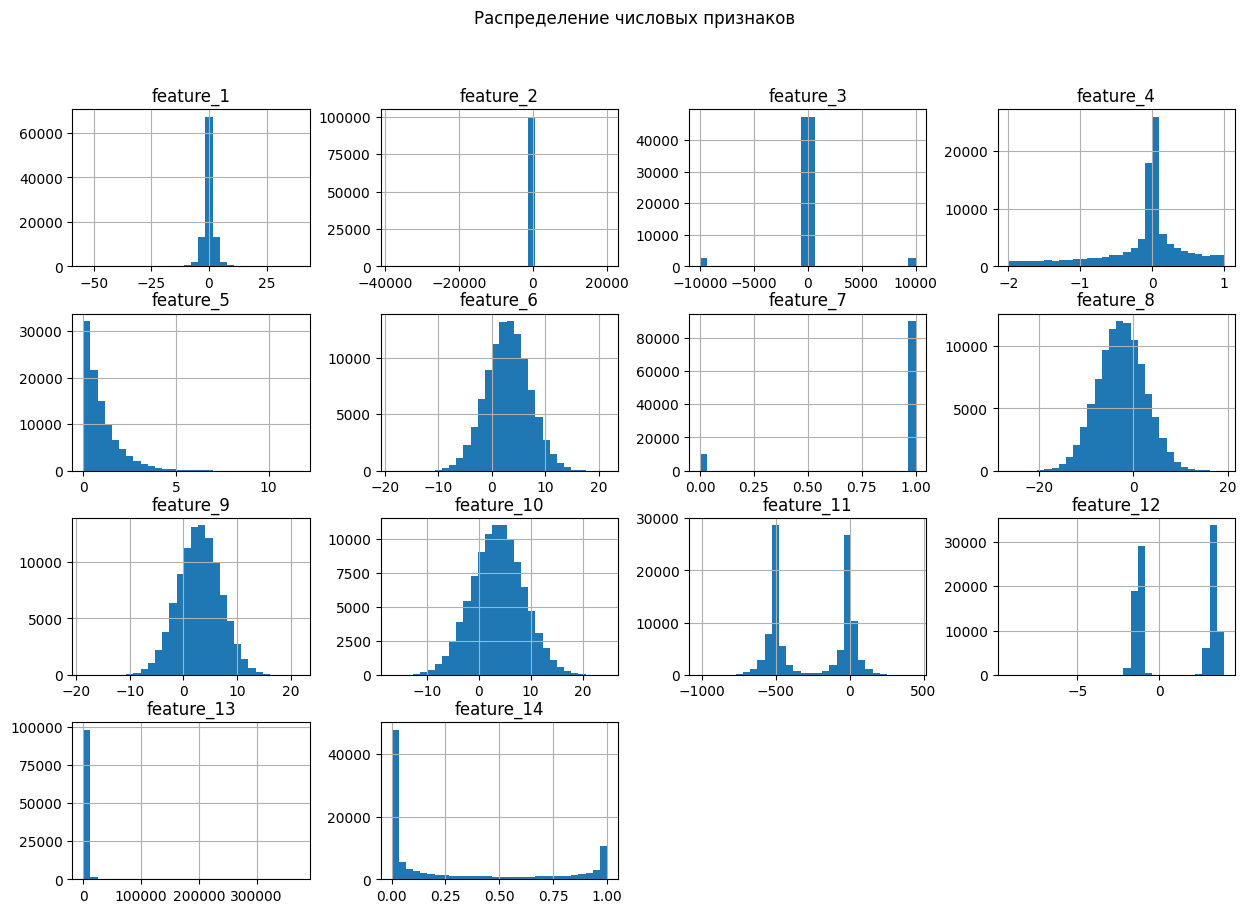

In [ ]:
num_features = [f'feature_{i}' for i in range(1, 15)]
df[num_features].hist(figsize=(15,10), bins=30)
plt.suptitle('Распределение числовых признаков')
plt.show()

Видим распределения с тяжелыми хвостами, с несколькими признаки нужно поработать отдельно, чтобы линеаризовать их

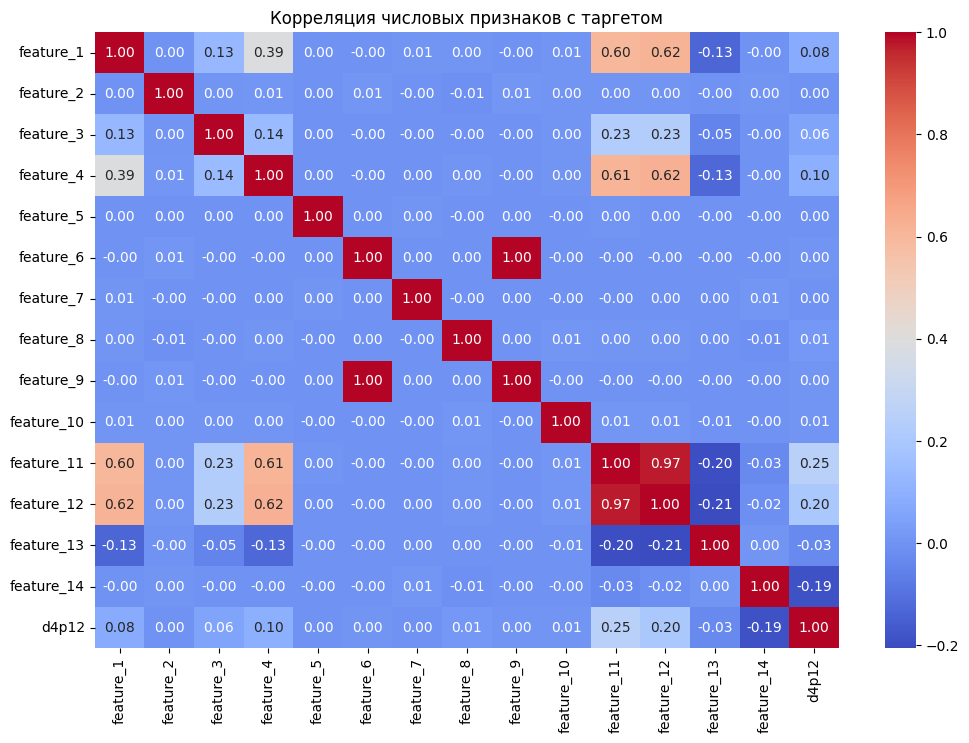

In [ ]:
corr = df[num_features + ['d4p12']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляция числовых признаков с таргетом')
plt.show()

Видим сильную корреляцию некоторых признаков друг с другом (feature_9 и feature_6, например). Есть вероятность проблемы мультиколлинеарности

С таргетом наибольшая корреляция у:
- feature_11
- feature_12
- feature_14


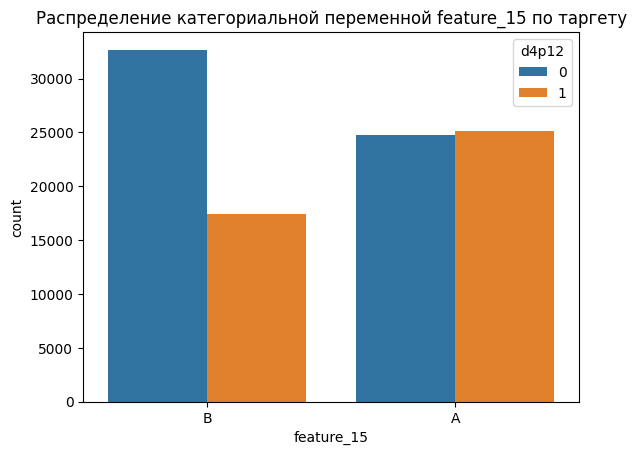

In [ ]:
sns.countplot(data=df, x='feature_15', hue='d4p12')
plt.title('Распределение категориальной переменной feature_15 по таргету')
plt.show()

В feature_15 значение "B" внесет вклад в предсказывание таргета

### Задание 1. Бейзлайн.

Попробуйте построить ЛогРег только на числовых данных. Для этого разбейте датасет на трейн и тест (80/20). Перед обучением логрега стандартизуйте переменные. Это может быть полезно для численной устойчивости алгоритмов оптимизации.

Для этой модели и всех дальнейших:

1. Получилась ли модель линейной? Постройте график линейности на трейне и на тесте и сделайте вывод.
2. Расчитайте AUC и IV на трейне и на тесте. Что можно сказать о переобучении?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [ ]:
df = df.dropna()

In [ ]:
num_features = [f'feature_{i}' for i in range(1, 15)]
X = df[num_features].values
y = df['d4p12'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
y_train_proba = logreg.predict_proba(X_train_scaled)[:, 1]
y_test_proba  = logreg.predict_proba(X_test_scaled)[:, 1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test  = roc_auc_score(y_test, y_test_proba)

print(f'AUC train: {auc_train:.3f}')
print(f'AUC test : {auc_test:.3f}')

AUC train: 0.705
AUC test : 0.714


AUC достаточно высокий, на тесте больше, чем на трейне, что говорит об отсутствии переобучения

In [ ]:
for i in range(X_train.shape[1]):
    feature_name = f'feature_{i+1}'
    x_train_feat = X_train_scaled[:, i]

    print(f'{feature_name}:')

    fig = woe_line(values=x_train_feat, target=y_train, n_buckets=5)
    fig.show()

feature_1:


feature_2:


feature_3:


feature_4:


feature_5:


feature_6:


feature_7:


feature_8:


feature_9:


feature_10:


feature_11:


feature_12:


feature_13:


feature_14:


Видим, что признаки далеко не линейны, стоит поработать с ними

Также судя по метрикам, большинство признаков почти не разделяют классы (AUC близки к 0.5, IV маленькие), только feature_11 и feature_12 показывают хорошую разделительную силу, а R2 также сигнализирует о нелинейной зависимости



In [ ]:
def calc_iv_model(y_true, y_pred, n_buckets):
    buckets = calc_buckets(y_pred, n_buckets)
    B = y_true.sum()
    G = len(y_true) - B
    woe_vals, _, _ = woe_ci(y_true, buckets, offset=logit(B/(B+G)))
    IV = 0.0
    for b in np.unique(buckets):
        idx = buckets == b
        B_i = y_true[idx].sum()
        G_i = len(idx) - B_i
        IV += ((B_i/B) - (G_i/G)) * woe_vals[b]
    return IV

In [ ]:
iv_train = calc_iv_model(y_train, y_train_proba, n_buckets=5)
iv_test = calc_iv_model(y_test, y_test_proba, n_buckets=5)

print(f'IV train: {iv_train:.3f}, IV test: {iv_test:.3f}')

IV train: 0.818, IV test: 0.909


IV не слишком высокое, что говорит о слабой разделяющей силе признаков. На тесте показатель больш, переобучения нет

In [ ]:
# График линейности на трейне:

woe_line(values=y_train_proba, target=y_train, n_buckets=5)

In [ ]:
# График линейности на тесте:

woe_line(values=y_test_proba, target=y_test, n_buckets=10)

Сама модель почти линейная (все не так плохо по сравнению с графика по признакам, однако стоит поработать с ними)

### Задание 2. Добавляем категориальную переменную.

Повторите задание 1, включив в модель категориальную переменную (например, с помощью one-hot encoding).

Улучшилось ли качество?

In [ ]:
from sklearn.preprocessing import OneHotEncoder

num_features = [f'feature_{i}' for i in range(1, 15)]
cat_features = ['feature_15']

X_num = df[num_features]
X_cat = df[cat_features]
y = df['d4p12']

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat_encoded = encoder.fit_transform(X_cat)
cat_columns = encoder.get_feature_names_out(cat_features)
X_cat_encoded = pd.DataFrame(X_cat_encoded, columns=cat_columns, index=df.index)

scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=num_features, index=df.index)

X_full = pd.concat([X_num_scaled, X_cat_encoded], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f'AUC train: {auc_train:.3f}')
print(f'AUC test : {auc_test:.3f}')

AUC train: 0.860
AUC test : 0.858


AUC увеличился и на трейне, и на тесте по сравнению с прошлой моделью!! то есть модель стала "умнее". При этом AUC на тесте больше, чем на трейне, то есть переобучения нет

In [ ]:
for i in range(X_train.shape[1]):
    feature_name = f'feature_{i+1}'
    x_train_feat = X_train.iloc[:, i].values

    print(f'{feature_name}:')

    fig = woe_line(values=x_train_feat, target=y_train, n_buckets=5)
    fig.show()

feature_1:


feature_2:


feature_3:


feature_4:


feature_5:


feature_6:


feature_7:


feature_8:


feature_9:


feature_10:


feature_11:


feature_12:


feature_13:


feature_14:


feature_15:


Если смотрим WoE по каждому признаку отдельно, то у нас все так же сохраняется нелинейность

In [ ]:
iv_train = calc_iv_model(y_train, y_train_pred, n_buckets=5)
iv_test = calc_iv_model(y_test, y_test_pred, n_buckets=5)

print(f'IV train: {iv_train:.3f}, IV test: {iv_test:.3f}')

IV train: 3.710, IV test: 3.772


IV также повысился!! разделяющая "сила" модели стала больше) и переобучения также не наблбдается: IV на тесте больше, чем на трейне

In [ ]:
# График линейности на трейне:

woe_line(values=y_train_pred, target=y_train, n_buckets=5)

In [ ]:
# График линейности на тесте:

woe_line(values=y_test_pred, target=y_test, n_buckets=5)

Более того модель стала более линейной! Добавление категориального признака творит чудеса)

### Задание 3. Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег).

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используйте переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуйте переменные. Для этого приложите:
 - график линейности переменной до преобразования
 - график после подобранного преобразования

Помимо этого:
 - попробуйте линеаризовать какие-нибудь 2 переменные *на всей выборке*. Получилось ли у вас что-то? Постройте график.
 - по графику линейности определите шумовые (либо слабоинформативные) переменные. В конце задания приложите их список.

Сначала попробую линеаризовать переменные feature_10 и feature_14 на всей выборке

In [ ]:
woe_line(values=X_train['feature_10'].values, target=y_train.values, n_buckets=5)

In [ ]:
woe_line(values=np.log(X_train['feature_10'].values - X_train['feature_10'].values.min() + 1), target=y_train.values, n_buckets=5)

In [ ]:
woe_line(values=X_train['feature_14'].values, target=y_train.values, n_buckets=5)

In [ ]:
woe_line(values=np.log(X_train['feature_14'].values - X_train['feature_14'].values.min() + 1), target=y_train.values, n_buckets=5)

Признаки становятся чуть более линейными (но они все еще нелинейны), однако попробуем разделить их по сегментам, чтобы сделать модель еще лучше

In [ ]:
df['feature_15'].unique()

array(['B', 'A'], dtype=object)

Два сегмента: B и A

In [ ]:
# A
mask = X_train['feature_15_B'] == 0
X_A = X_train[mask]
y_A = y_train[mask]

In [ ]:
x_featA = X_A['feature_1'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

Признак не совсем линейный. Попробуем прологарифмировать, чтобы "сжать" большие значения

In [ ]:
x_featA = X_A['feature_1'].values
x_featA = np.log(x_featA)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

R2 увеличился, признак стал линейным, оставим признак преобразованным

In [ ]:
x_featA = X_A['feature_2'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
x_featA = X_A['feature_2'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

Признак явно нелинейный, линеаризовать сложно: имеющих смысл монотонных преобразований провести не сможем, оставляет таким

In [ ]:
x_featA = (X_A['feature_3'].values)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

Заметим "тяжелый хвост" слева, прологарифмируем)

In [ ]:
x_featA = X_A['feature_3'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

Мало что изменилось, но R2 вырос, оставляем признак преобразованным

In [ ]:
x_featA = X_A['feature_4'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
x_featA = X_A['feature_4'].values
x_featA = np.log(x_featA)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

R2 увеличился, оставим преобразованный признак, но признак все еще нелинейный

In [ ]:
x_featA = X_A['feature_5'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
x_featA = X_A['feature_5'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

R2 уменьшился, оставляем признак таким, каким был (но он нелинейный)

In [ ]:
x_featA = X_A['feature_6'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
x_featA = X_A['feature_6'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

R2 вырос, но признак все еще нелинейный

In [ ]:
x_featA = X_A['feature_7'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
np.unique(X_A['feature_7'].values)

array([-3.00467613,  0.33281457])

Так как всего два значения признака, то преобразовать мы его не сможем

In [ ]:
x_featA = X_A['feature_8'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
x_featA = X_A['feature_8'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

R2 вырос после логарифмирования, оставляем так

In [ ]:
x_featA = X_A['feature_9'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
x_featA = X_A['feature_9'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

R2 вырос, но признак все еще нелинейный

In [ ]:
x_featA = X_A['feature_10'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
x_featA = X_A['feature_10'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

После логарифмирования R2 немного увеличился, оставляем, но признак все еще нелинейный

In [ ]:
x_featA = X_A['feature_11'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

In [ ]:
x_featA = X_A['feature_11'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

Логарифмирование уменьшило R2, оставляем, как было

In [ ]:
x_featA = X_A['feature_12'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

Признак и так достаточно линейный, оставляем

In [ ]:
x_featA = X_A['feature_13'].values
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

"Шумный" нелинейный признак, оставляем так

In [ ]:
x_featA = (X_A['feature_14'].values)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

Прологарифмируем)

In [ ]:
x_featA = X_A['feature_14'].values
x_featA = np.log(x_featA - x_featA.min() + 1)
woe_line(values=x_featA, target=y_A.values, n_buckets=5)

R2 увеличился, оставляем

Итого для сегмента A убираем признаки (по причине нелинейности):
- feature_2
- feature_3
- feature_4
- feature_5
- feature_6
- feature_9
- feature_10
- feature_13

Тогда остаются признаки:
- feature_1 (log)
- feature_7
- feature_8
- feature_11
- feature_12
- feature_14 (log)

In [ ]:
# B
mask = X_train['feature_15_B'] == 1
X_B = X_train[mask]
y_B = y_train[mask]

In [ ]:
x_featB = X_B['feature_1'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_1'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

Признак был достаточно линейным, оставляем, как есть

In [ ]:
x_featB = X_B['feature_2'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_2'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 чуть увеличился, однако признак все еще нелинейный

In [ ]:
x_featB = X_B['feature_3'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_3'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 уменьшился, поэтому оставляем, как было, однако признак все еще нелинейный

In [ ]:
x_featB = X_B['feature_4'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_4'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 не изменился, признак все еще нелинейный

In [ ]:
x_featB = X_B['feature_5'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_5'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 увеличился, но признак все еще не совсем линейный

In [ ]:
x_featB = X_B['feature_6'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_6'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 уменьшился, оставляем , как было

In [ ]:
x_featB = X_B['feature_8'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_8'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 уменьшился, оставляем, как есть, признак не совсем линейный

In [ ]:
x_featB = X_B['feature_9'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_9'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 уменьшился, оставляем, как было

In [ ]:
x_featB = X_B['feature_10'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_10'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 увеличился, оставляем преобразованный признак

In [ ]:
x_featB = X_B['feature_11'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_11'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 увеличился, оставляем преобразованный признак

In [ ]:
x_featB = X_B['feature_12'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

Почти линейный признак, оставляем как есть

In [ ]:
x_featB = X_B['feature_13'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

"Шумный" нелинейный признак

In [ ]:
x_featB = X_B['feature_14'].values
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

In [ ]:
x_featB = X_B['feature_14'].values
x_featB = np.log(x_featB - x_featB.min() + 1)
woe_line(values=x_featB, target=y_B.values, n_buckets=5)

R2 увеличился, оставляем преобразованный признак

Итого для сегмента B убираем признаки (по причине нелинейности):

- feature_2
- feature_3
- feature_4
- feature_5
- feature_8
- feature_13

Тогда остаются признаки:

- feature_1
- feature_6
- feature_7
- feature_9
- feature_10 (log)
- feature_11 (log)
- feature_12
- feature_14 (log)

### Задание 4. Финальная модель.

Обучите модели на признаках, которые вы отобрали и линеаризовали в задании 3. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$


Посчитайте для этой модели AUC и IV, оцените линейность на трейне и тесте. Сравните результаты с бейзлайном из задания 1.

Подсказка: если вы все сделали правильно, можно ожидать ROC AUC около 0.9 на тестовой выборке.

In [ ]:
maskB_train = X_train['feature_15_B'] == 1
maskA_train = X_train['feature_15_B'] == 0

maskB_test = X_test['feature_15_B'] == 1
maskA_test = X_test['feature_15_B'] == 0

In [ ]:
def transform_A(X):
    X_new = pd.DataFrame(index=X.index)
    x1 = X['feature_1']
    X_new['feature_1']  = np.log(x1 - x1.min() + 1)
    X_new['feature_7']  = X['feature_7']
    X_new['feature_8']  = X['feature_8']
    X_new['feature_11'] = X['feature_11']
    X_new['feature_12'] = X['feature_12']
    x14 = X['feature_14']
    X_new['feature_14'] = np.log(x14 - x14.min() + 1)
    return X_new

In [ ]:
def transform_B(X):
    X_new = pd.DataFrame(index=X.index)
    X_new['feature_1']  = X['feature_1']
    X_new['feature_6']  = X['feature_6']
    X_new['feature_7']  = X['feature_7']
    X_new['feature_9']  = X['feature_9']
    x10 = X['feature_10']
    X_new['feature_10'] = np.log(x10 - x10.min() + 1)
    x11 = X['feature_11']
    X_new['feature_11'] = np.log(x11 - x11.min() + 1)
    X_new['feature_12'] = X['feature_12']
    x14 = X['feature_14']
    X_new['feature_14'] = np.log(x14 - x14.min() + 1)
    return X_new

In [ ]:
XA_train = transform_A(X_train.loc[maskA_train])
XA_test  = transform_A(X_test.loc[maskA_test])
yA_train = y_train.loc[maskA_train]
yA_test  = y_test.loc[maskA_test]

XB_train = transform_B(X_train.loc[maskB_train])
XB_test  = transform_B(X_test.loc[maskB_test])
yB_train = y_train.loc[maskB_train]
yB_test  = y_test.loc[maskB_test]

In [ ]:
logitA = LogisticRegression()
logitB = LogisticRegression()

logitA.fit(XA_train, yA_train)
logitB.fit(XB_train, yB_train)

LogisticRegression()

In [ ]:
y_train_pred = np.zeros(len(X_train))
y_train_pred[maskA_train] = logitA.predict_proba(XA_train)[:, 1]
y_train_pred[maskB_train] = logitB.predict_proba(XB_train)[:, 1]

y_test_pred = np.zeros(len(X_test))
y_test_pred[maskA_test] = logitA.predict_proba(XA_test)[:, 1]
y_test_pred[maskB_test] = logitB.predict_proba(XB_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, y_train_pred)
auc_test  = roc_auc_score(y_test, y_test_pred)

iv_train = calc_iv_model(y_train.values, y_train_pred, n_buckets=5)
iv_test  = calc_iv_model(y_test.values, y_test_pred, n_buckets=5)

print(f'AUC train: {auc_train:.3f}, IV train: {iv_train:.3f}')
print(f'AUC test : {auc_test:.3f}, IV test : {iv_test:.3f}')

AUC train: 0.871, IV train: 4.002
AUC test : 0.867, IV test : 3.934


Было:
- AUC train: 0.860, IV train: 3.710
- AUC test : 0.858, IV test: 3.772

Ура! у нас увеличились все метрики, и AUC на трейне близко к 0,9 (как и. бало сказано в подсказке :)

IV увеличилось, что говорит о большИх смысле и силе в разделяющейся споосбности переменных

Однако появились признаки переобучения: AUС на трейне больше, чем на тесте

In [ ]:
# График линейности на трейне:

woe_line(values=y_train_pred, target=y_train, n_buckets=5)

In [ ]:
# График линейности на тесте:

woe_line(values=y_test_pred, target=y_test, n_buckets=5)

Модели почти линейные)

# Часть 3. Бонус. (3 балла)

На лекции мы накопили ряд упражнений, которые стоит решить для понимания происходившего. Вы можете $\TeX$ать их прямо в ноуте (или прикреплять картинки, если так удобнее).

#### **Упражнение 1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Примените ее и **покажите, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

```
your solution here
```


По теореме Байеса:

$
P(x_i \mid y=1) = \frac{P(y=1 \mid x_i) P(x_i)}{P(y=1)}, \quad
P(x_i \mid y=0) = \frac{P(y=0 \mid x_i) P(x_i)}{P(y=0)}
$

Подставим:

$
\frac{P(x_i \mid y=1)}{P(x_i \mid y=0)}
= \frac{P(y=1 \mid x_i) / P(y=1)}{P(y=0 \mid x_i) / P(y=0)}
= \frac{P(y=1 \mid x_i)}{P(y=0 \mid x_i)} : \frac{P(y=1)}{P(y=0)}
$

Прологарифмируем:

$
\ln \frac{P(x_i \mid y=1)}{P(x_i \mid y=0)}
= \ln \frac{P(y=1 \mid x_i)}{P(y=0 \mid x_i)} - \ln \frac{P(y=1)}{P(y=0)}
$

Что и требовалось доказать

#### **Упражнение 2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажите, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

```
your solution here
```

$
WoE_i(x_i) = \ln\frac{B_i}{G_i} - \ln\frac{B}{G} = \ln\frac{\frac{B_i}{B_i + G_i}}{\frac{G_i}{B_i + G_i}} - \ln\frac{\frac{B}{B+G}}{\frac{G}{B+G}} = \ln \frac{\text{badrate}_i}{1 - \text{badrate}_i} - \ln \frac{\text{badrate}}{1 - \text{badrate}} = \text{logit}(\text{badrate}_i) - \text{logit}(\text{badrate})
$

Что и требовалось доказать

#### **Упражнение 3**

Пусть даны два дискретных распределения:

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принмиающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразите $IV$ через $WoE$**





```
your solution here
```

$
D_{KL}(B_x || G_x) = \sum_{i=1}^{n} b_i \ln \frac{b_i}{g_i}, \quad
D_{KL}(G_x || B_x) = \sum_{i=1}^{n} g_i \ln \frac{g_i}{b_i}
$

$
WoE_i = \ln \frac{b_i}{g_i}
$

Тогда

$
IV_x = \sum_{i=1}^{n} b_i \ln \frac{b_i}{g_i} + \sum_{i=1}^{n} g_i \ln \frac{g_i}{b_i}
= \sum_{i=1}^{n} b_i WoE_i + \sum_{i=1}^{n} g_i (-WoE_i)
= \sum_{i=1}^{n} (b_i - g_i) WoE_i
$

То есть
$
IV_x = \sum_{i=1}^{n} (B_x(x_i) - G_x(x_i)) \cdot WoE_i
$
